In [1]:
import pandas as pd
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_model = df.copy()

In [2]:
df_model = df_model.drop("customerID", axis=1)

In [3]:
df_model["TotalCharges"] = pd.to_numeric(df_model["TotalCharges"], errors="coerce")
df_model["TotalCharges"] = df_model["TotalCharges"].fillna(df_model["TotalCharges"].median())

In [4]:
df_model["Churn"] = df_model["Churn"].map({"Yes": 1,"No": 0})

In [5]:
cat_cols = df_model.select_dtypes(include="object").columns
num_cols = df_model.select_dtypes(include=["int64","float64"]).columns

In [6]:
df_model_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

In [7]:
X = df_model_encoded.drop('Churn', axis=1)
y = df_model_encoded['Churn']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
num_cols = ["tenure","MonthlyCharges","TotalCharges"]
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[924 111]
 [187 187]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


ROC-AUC: 0.8237567490764421


In [11]:
threshold = 0.40
y_pred_thr = (y_proba > threshold).astype(int)
print("Threshold:", threshold)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thr))

Threshold: 0.4
Confusion Matrix:
 [[869 166]
 [148 226]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [12]:
threshold = 0.35
y_pred_thr = (y_proba > threshold).astype(int)
print("Threshold:", threshold)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thr))

Threshold: 0.35
Confusion Matrix:
 [[827 208]
 [121 253]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409



              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409



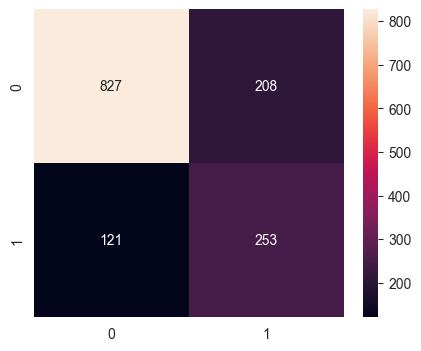

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
threshold =0.35
y_pred_thr = (y_proba > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_thr)
plt.figure(figsize = (5,4))
sns.heatmap(cm, annot=True, fmt="d")
print(classification_report(y_test, y_pred_thr))

**Threshold Tuning Sonuçları (Random Forest):**

- Varsayılan eşik (0.50) churn sınıfı için %50 recall sağlamıştır.
- Eşik 0.40’a düşürüldüğünde churn recall %60’a yükselmiştir.
- Eşik 0.35’e düşürüldüğünde churn recall %68 seviyesine ulaşmıştır.

İş problemi gereği churn müşterilerini kaçırmanın maliyeti,
yanlış pozitif tahmin maliyetinden daha yüksek olduğundan,
final model için threshold = 0.35 seçilmiştir.

In [14]:
import pandas as pd
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance.head(10)

,Feature,Importance
3,TotalCharges,0.177844
1,tenure,0.164403
2,MonthlyCharges,0.151054
25,Contract_Two year,0.059944
10,InternetService_Fiber optic,0.042323
28,PaymentMethod_Electronic check,0.036455
24,Contract_One year,0.029412
13,OnlineSecurity_Yes,0.028447
4,gender_Male,0.025604
26,PaperlessBilling_Yes,0.024087


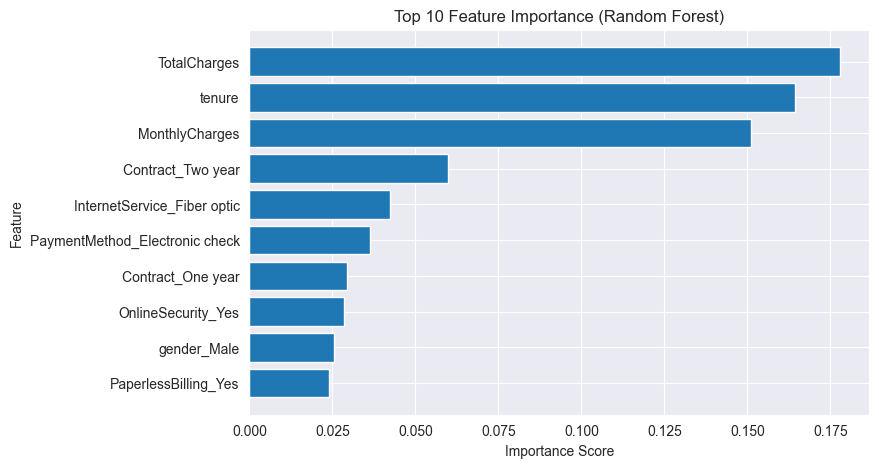

In [15]:
import matplotlib.pyplot as plt
top_features = feature_importance.head(10)

plt.figure(figsize = (8,5))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

### Feature Importance (Random Forest)
Random Forest modeline göre churn tahmininde en etkili değişkenler;
müşteri süresi (tenure), aylık ücret (MonthlyCharges) ve toplam harcama (TotalCharges) olmuştur.
Ayrıca sözleşme tipi ve ödeme yöntemi gibi faktörlerin de churn davranışı üzerinde önemli etkileri olduğu gözlemlenmiştir.

In [16]:
import pandas as pd
final_threshold = 0.35
risk_df = pd.DataFrame({
    "Churn_Probability": y_proba,
    "Predicted_Churn": (y_proba > final_threshold).astype(int)
}, index=X_test.index)
risk_df.head()

,Churn_Probability,Predicted_Churn
437,0.000000,0
2280,0.786667,1
2235,0.090000,0
4460,0.280000,0
3761,0.000000,0


In [17]:
risk_df["Risk_Segment"] = pd.qcut(
    risk_df["Churn_Probability"],
    q=[0, 0.8, 0.9, 0.95, 1.0],
    labels=["Low", "Medium", "High","Very High"]
)
risk_df["Risk_Segment"].value_counts()

Risk_Segment
Low          1129
Medium        140
Very High      71
High           69
Name: count, dtype: int64

In [18]:
campaign_targets = risk_df[risk_df["Risk_Segment"] == "Very High"]

campaign_targets.sort_values(
    "Churn_Probability",ascending=False
).head(10)

,Churn_Probability,Predicted_Churn,Risk_Segment
1731,1.000000,1,Very High
2927,0.993333,1,Very High
2194,0.993333,1,Very High
1739,0.993333,1,Very High
809,0.990000,1,Very High
6623,0.990000,1,Very High
3346,0.970000,1,Very High
1144,0.963333,1,Very High
4585,0.960000,1,Very High
2729,0.950000,1,Very High


### Churn Risk Segmentation & Campaign Targeting

Model olasılık çıktıları kullanılarak müşteriler churn riskine göre
segmentlere ayrılmıştır (Low, Medium, High, Very High).
Özellikle **Very High risk (top %5)** segmenti, kampanya ve müşteri elde tutma aksiyonları için öncelikli hedef kitle olarak belirlenmiştir.